In [14]:
!pip install transformers
!pip3 install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.5 MB/s eta 0:00:0000:0100:01
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
  Using cached huggingface_hub-0.13.3-py3-none-any.whl (199 kB)
  Using cached filelock-3.10.7-py3-none-any.whl (10 kB)
  Using cached tokenizers-0.13.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached regex-2023.3.23-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (771 kB)
  Using cached torch-2.0.0-cp38-cp38-manylinux1_x86_64.whl (619.9 MB)
  Using cached torchvision-0.15.1-cp38-cp38-manylinux1_x86_64.whl (33.8 MB)
  Using cached torchaudio-2.0.1-cp38-cp38-manylinux1_x86_64.whl (4.4 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_6

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import cv2

In [2]:
def get_contour(img):
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey, (7, 7), 0)
    edges = cv2.Canny(blur, 50, 100, apertureSize=3)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(edges, kernel, iterations=2)
    contour_img, contours, hierarchy = cv2.findContours(
        dilation,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    contour_img = img.copy()
    contour_img = cv2.drawContours(contour_img, [cnt], 0, (0, 255, 0), 3)
    return contour_img, cnt

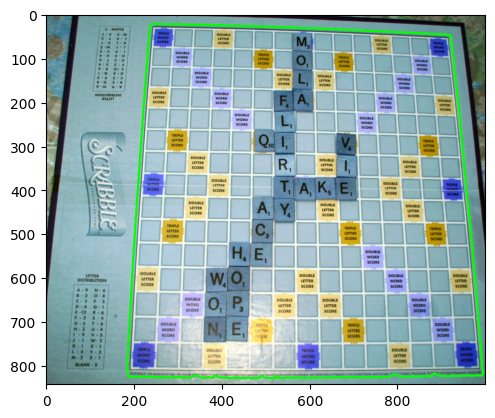

In [3]:
filename = 'board1.jpeg'
img = cv2.imread(filename,1)

contour_img, cnt = get_contour(img)

plt.imshow(contour_img,cmap = 'gray')

In [4]:
def get_corners(cnt):
    epsilon = 0.01*cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    return [x[0] for x in approx]


In [5]:
def rescale_image(corners, img, out_size = 400):
    tl, tr, bl, br = None, None, None, None
    m_x = sum([tp[0]/4 for tp in corners])
    m_y = sum([tp[1]/4 for tp in corners])
    for tp in corners:
        if tp[0] > m_x and tp[1]>m_y:
            br = tp
            nbr = [out_size, out_size]
        elif tp[0] < m_x and tp[1]>m_y:
            bl = tp
            nbl = [0, out_size]
        elif tp[0] < m_x and tp[1]<m_y:
            tl = tp
            ntl = [0, 0]
        elif tp[0] > m_x and tp[1]<m_y:
            tr = tp
            ntr = [out_size, 0]
    input_pts = np.float32([tl, tr, br, bl])
    print(input_pts)
    output_pts = np.float32([ntl, ntr, nbr, nbl])        
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out = cv2.warpPerspective(img,M,(out_size, out_size),flags=cv2.INTER_LINEAR)
    return out
            
        

[[239.  23.]
 [921.  48.]
 [993. 822.]
 [187. 824.]]


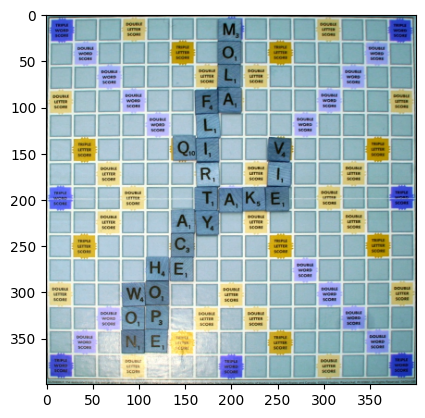

In [6]:
corners = get_corners(cnt)
out = rescale_image(corners, img)
scaled_img = out
plt.imshow(out,cmap = 'gray')

In [7]:
def extract_cell(i,j,scaled_img):
    size = scaled_img.shape[0]
    cell_size = size/15
    cell_img = scaled_img[int(i*cell_size):int((i+1)*cell_size), int(j*cell_size):int((j+1)*cell_size)]
    return cell_img
    
cell_img = extract_cell(5,9,scaled_img)


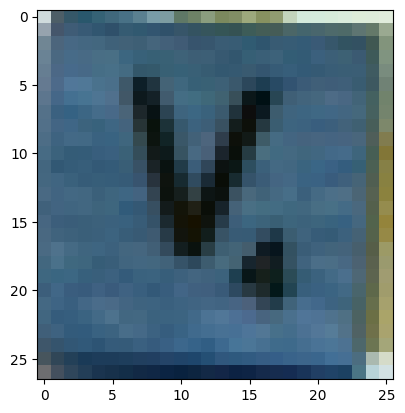

In [8]:
plt.imshow(cell_img,cmap = 'gray')

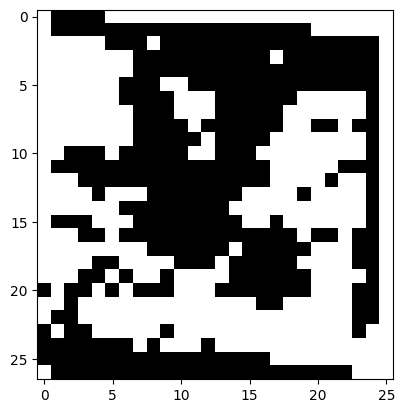

In [12]:
def preprocess_cell(cell_img):
    grey = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey, (1, 1), 0)
    ret, imgf = cv2.threshold(blur, 100, 255,cv2.THRESH_BINARY)
    #th3 = cv2.adaptiveThreshold(grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2)
    return cv2.cvtColor(imgf, cv2.COLOR_GRAY2BGR)

cell_img = extract_cell(5,9,scaled_img)
plt.imshow(preprocess_cell(cell_img),cmap = 'gray')

In [15]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import torch

extractor = AutoFeatureExtractor.from_pretrained("pittawat/vit-base-letter")

model = AutoModelForImageClassification.from_pretrained("pittawat/vit-base-letter")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [16]:
def predict_letter(cell_img):
    processed_img = extractor(cell_img,return_tensors="pt")
    logits = model(**processed_img)
    predicted_label = logits['logits'].argmax(-1).item()
    return model.config.id2label[predicted_label]
    


In [24]:
cell_img = preprocess_cell(extract_cell(5,10,scaled_img))

prediction = predict_letter(cell_img)
print(prediction)

J


In [23]:
prediction = predict_letter(cell_img)

In [25]:
def get_grid_complete(scaled_img):
    res = []
    for j in range(15):
        print(j)
        row = []
        for i in range(15):
            print(i)
            cell_img = preprocess_cell(extract_cell(i,j,scaled_img))
            prediction = predict_letter(cell_img)
            row.append(prediction)
        res.append(row)
    return res
    

In [26]:
get_grid_complete(scaled_img)

0
0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 